In [3]:
pip install tonic

   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.8/3.0 MB 2.4 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/3.0 MB 2.0 MB/s eta 0:00:01
   ----------------- ---------------------- 1.3/3.0 MB 1.8 MB/s eta 0:00:01
   --------------------- ------------------ 1.6/3.0 MB 1.6 MB/s eta 0:00:01
   ------------------------ --------------- 1.8/3.0 MB 1.5 MB/s eta 0:00:01
   ---------------------------- ----------- 2.1/3.0 MB 1.4 MB/s eta 0:00:01
   ------------------------------- -------- 2.4/3.0 MB 1.4 MB/s eta 0:00:01
   ----------------------------------- ---- 2.6/3.0 MB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -----------------------------

In [4]:
# Imports 
import os
# Important: insert the path to synaptic_plasticity/src
os.chdir('\SynologyDrive\Downloads\synaptic_plasticity-separated_data_loading(1)\synaptic_plasticity-separated_data_loading\src')
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import spikingjelly
import utils
import network
from spikingjelly.activation_based import functional

C:\Users\Hanna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading a random MNIST image

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:43<00:00, 226319.86it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 302566.17it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1006444.55it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4521844.00it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



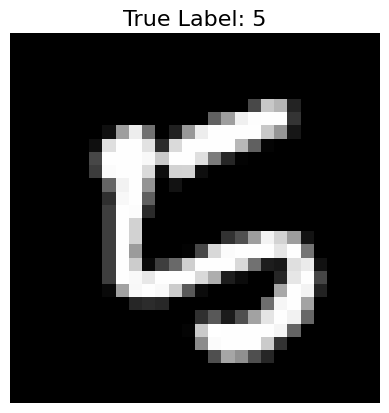

In [57]:
# Select a random sample
sample_idx = random.randint(0, len(mnist) - 1)
sample, label = mnist[sample_idx]

# Visualize the sample
plt.imshow(sample.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f"True Label: {label}")
plt.show()

## Encoding static image into spike trains

In [7]:
_, testing_loader = utils.load_MNIST()
encoded, encoded_label = testing_loader.dataset[sample_idx]

0


In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from IPython.display import HTML

# Sample tensor data (replace this with your actual tensor)
data = encoded  # Shape: [15, 6, 28, 28]

# Convert to numpy array for plotting
data_np = data.numpy()

# Create a figure and subplots
fig, axs = plt.subplots(1, 6, figsize=(18, 3))
fig.patch.set_facecolor('lightsalmon')

# Hide the axes for a cleaner display
for ax in axs:
    ax.axis('off')

# Animation update function
def update(t):
    for i, ax in enumerate(axs):
        ax.imshow(data_np[t, i], cmap='grey')
        ax.set_title(f'Channel = {i}', color='white', fontsize=10, fontweight='bold')
    return axs

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=15, interval=200, blit=False)

# Close the figure to prevent the initial plot from showing
plt.close(fig)

# Display the animation
HTML(ani.to_jshtml())


## Insert the encoded MNIST sample into the model

In [9]:
net = network.Network(number_of_classes=10)

(-0.5, 4.5, 4.5, -0.5)

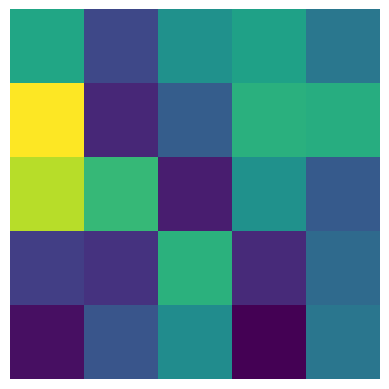

In [10]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')

In [11]:
latest_checkpoint_path = utils.get_latest_checkpoint('../checkpoints/experiment_1')
if latest_checkpoint_path:
    # Load the checkpoint if found
    start_epoch, training_layer = utils.load_checkpoint(net,
                                                    latest_checkpoint_path)

Latest checkpoint found: checkpoint_20240829-082540_epoch_39.pth
Checkpoint loaded: epoch 40, training layer 3.


(-0.5, 4.5, 4.5, -0.5)

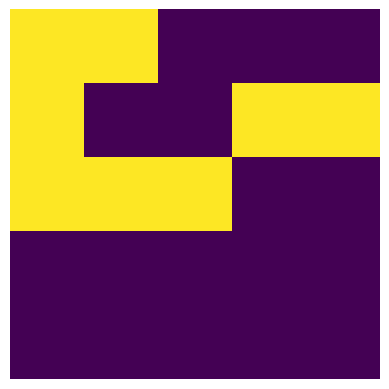

In [12]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')

In [13]:
encoded_label

1

In [14]:
# Use multistep mode for faster training
functional.set_step_mode(net, step_mode='m')
frame = encoded.to('cpu:0')
frame = frame.unsqueeze(dim=0)
frame = frame.transpose(0, 1)
frame = frame.float()
_ = net(frame)

In [15]:
# Extract the decision value as an integer
decision = net.get_decision()
decision_value = int(decision.numpy()[0])

# Determine if the decision is correct
result = "Correct 😀" if decision_value == label else "Incorrect 😭"

# Print the result
print(f"The network decided: {decision_value}\nThe true label: {label}\n{result}")

The network decided: 5
The true label: 1
Incorrect 😭


## Loading a random N-MNIST sample

In [58]:
import tonic
from torch.utils.data import DataLoader

# Load the N-MNIST dataset
n_mnist = tonic.datasets.NMNIST(save_to='./data_n_mnist', train=True)
# Create DataLoader for training and testing
n_mnist_loader = DataLoader(n_mnist, batch_size=100, shuffle=True)

Sample Index: 2210, Label: 0


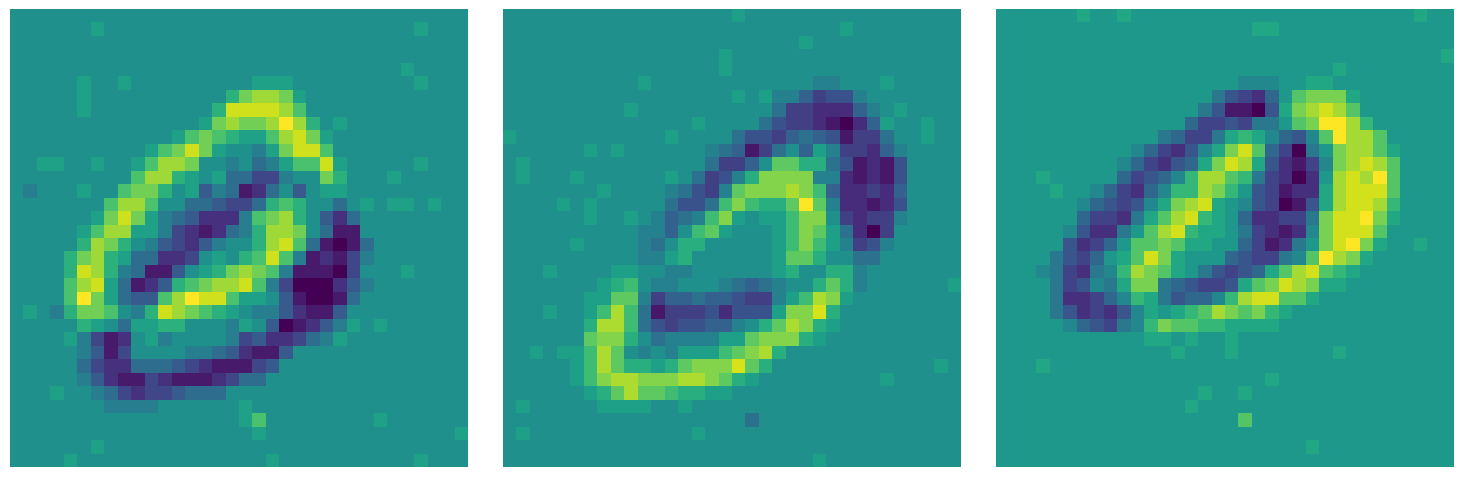

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import tonic.transforms as transforms
import random

# Define the transform
sensor_size = tonic.datasets.NMNIST.sensor_size
frame_transform = transforms.ToFrame(sensor_size=sensor_size, n_time_bins=3)

# Select a random sample
sample_idx = random.randint(0, len(n_mnist) - 1)
sample_spiking, label_spiking = n_mnist[sample_idx]
# Debugging: Print sample index and label
print(f"Sample Index: {sample_idx}, Label: {label_spiking}")

# Apply the transform to the sample
def apply_transform(events, transform):
    frames = transform(events)
    return frames

frames = apply_transform(sample_spiking, frame_transform)

# Function to plot frames
def plot_frames(frames):
    num_frames = len(frames)
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

    if num_frames == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one frame

    for axis, frame in zip(axes, frames):
        # Subtract the ON and OFF polarities to get the difference
        # Assuming the shape of frame is (Time, Number of polarities, Height, Width)
        frame_diff = frame[1] - frame[0]  # Difference between polarities
        axis.imshow(frame_diff)
        axis.axis("off")


    plt.tight_layout()
    plt.show()

# Plot the original frames
plot_frames(frames)

## Encode Spike traces

In [72]:
_, testing_loader = utils.load_NMNIST()
encoded, encoded_label = testing_loader.dataset[sample_idx]

1011894272it [33:56, 496834.52it/s]                                 


Extracting ../../tutorials/data\NMNIST\train.zip to ../../tutorials/data\NMNIST


169675776it [05:39, 499961.59it/s]                                


Extracting ../../tutorials/data\NMNIST\test.zip to ../../tutorials/data\NMNIST


C:\Users\Hanna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [75]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Check the number of frames available
num_frames = data_np.shape[0]  # Assuming data_np has shape (num_frames, channels, height, width)

# Create a figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 2 channels (ON/OFF)
fig.patch.set_facecolor('lightsalmon')

# Hide the axes for a cleaner display
for ax in axs:
    ax.axis('off')

# Animation update function
def update(t):
    for i, ax in enumerate(axs):
        ax.imshow(data_np[t, i], cmap='gray')  # Show the ON and OFF channels separately
        ax.set_title(f'Channel = {i}', color='white', fontsize=10, fontweight='bold')
    return axs

# Adjust the number of frames to be within the bounds of available frames
num_frames_to_show = min(15, num_frames)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=num_frames_to_show, interval=200, blit=False)

# Close the figure to prevent the initial plot from showing
plt.close(fig)

# Display the animation
HTML(ani.to_jshtml())




## Insert the encoded N-MNIST sample into the model

In [78]:
#import network_two_channels
net = network.Network(input_channels=2, number_of_classes=10)

In [79]:
latest_checkpoint_path = utils.get_latest_checkpoint('../checkpoints/experiment_2')
if latest_checkpoint_path:
    # Load the checkpoint if found
    start_epoch, training_layer = utils.load_checkpoint(net,
                                                    latest_checkpoint_path)

Latest checkpoint found: checkpoint_20240831-080532_epoch_20.pth
Checkpoint loaded: epoch 21, training layer 3.


(-0.5, 4.5, 4.5, -0.5)

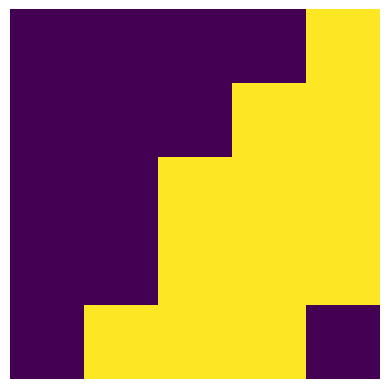

In [80]:
plt.imshow(net.conv1.weight.detach().numpy()[0,0])
plt.axis('off')

In [85]:
# Perform a forward pass
with torch.no_grad():
    _ = net(frame)  

# Extract the decision value as an integer
decision = net.get_decision()


# Determine if the decision is correct
result = "Correct 😀" if decision_value == label else "Incorrect 😭"

# Print the result
print(f"The network decided: {decision_value}\nThe true label: {label}\n{result}")

RuntimeError: Given groups=1, weight of size [30, 2, 5, 5], expected input[15, 6, 28, 28] to have 2 channels, but got 6 channels instead

## Final plot summarizing the training and testing accuracies of the experimental runs

![alt text](../photo_2024-08-31_11-07-50.jpg)